In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
plt.style.use('fivethirtyeight')

In [ ]:
# Import the time series data from CSV file
df=pd.read_csv('goldstock.csv')
df

In [ ]:
#Select the Data & Price Columns and copy them into a new data frame
Data = df[['Date', 'High']].copy()
#Set the data column to the standard pandas format 
Data['Date'] = pd.to_datetime(Data['Date'])
#Set the Date column as index 
Data.set_index('Date', inplace=True)
# Rename the price column "High" to "Gold_Stock_Price"
Data.rename(columns={'High': 'Gold_Stock_Price'}, inplace=True)
Data.head()

In [ ]:
# Visualize the time series data on a plot
Data.plot(style='.', figsize=(15,5), title='Daily Gold Price')

In [ ]:
#Split the time series data into 80 % for training and 20 % for testing
split_date = '01-Jan-2022'
train = Data.loc[Data.index <= split_date].copy()
test = Data.loc[Data.index > split_date].copy()

In [ ]:
# Visualize the splitted data on a plot
test.rename(columns={'Gold_Stock_Price': 'TEST SET'}).join(train.rename(columns={'Gold_Stock_Price': 'TRAINING SET'}), how='outer') \
.plot(figsize=(15,5), title='Daily Gold Price', style='.')

In [ ]:
# Extract the features of the time series data
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
   
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

X_train, y_train = create_features(train, label='Gold_Stock_Price')
X_test, y_test = create_features(test, label='Gold_Stock_Price')

In [ ]:
#Training the XGB model
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],verbose=False)

In [ ]:
plot_importance(reg, height=0.5)

In [ ]:
#Predict Gold price for the test dataset and add the result to a new column in the test dataset 
test['Gold_Stock_Price_Predictions'] = reg.predict(X_test)
predictions = pd.concat([test, train], sort=False)
predictions.head()

In [ ]:
#Plot the original time series data together with the predictions 
predictions[['Gold_Stock_Price','Gold_Stock_Price_Predictions']].plot(figsize=(20, 10))

In [ ]:
# Calculating the error metrics RMSE, MAE, MAPE

print("RMSE = ", mean_squared_error(y_true=test['Gold_Stock_Price'],y_pred=test['Gold_Stock_Price_Predictions']))
print("MAE = " , mean_absolute_error(y_true=test['Gold_Stock_Price'],y_pred=test['Gold_Stock_Price_Predictions']))
print("MAPE = ", mean_absolute_percentage_error(y_true=test['Gold_Stock_Price'],y_pred=test['Gold_Stock_Price_Predictions']))

In [1]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import HoltWinters
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
#Import time series data
df = pd.read_csv('goldstock.csv')
#Select the date and price columns and copy them into new data frame
Data = df[['Date', 'High']].copy()
#create a new column named 'unique_id' this is a requirement by StatsForecast library which assumes you have this column in your data
Data['unique_id'] = "Gold_Stock"
#set the data to the standard pandas format 
Data['Date'] = pd.to_datetime(df['Date'])
#rename the date and price columns into ds & y repectivly, this is also requirement by the StatsForecast library 
Data.rename(columns={'Date': 'ds', 'High': 'y'}, inplace=True)
Data.head()

,ds,y,unique_id
0,2024-01-19,2041.9,Gold_Stock
1,2024-01-18,2025.6,Gold_Stock
2,2024-01-17,2036.1,Gold_Stock
3,2024-01-16,2062.8,Gold_Stock
4,2024-01-12,2067.3,Gold_Stock


In [3]:
#select the model from StatsForecast library, and set the model parameters and fit our data using the selected model
sf = StatsForecast(models = [HoltWinters(season_length = 365)],freq = 'D')
sf.fit(Data)
#make future forecast with a chosen horizon of 365 days and ask for access for the fitted data
forecast_df = sf.forecast(df=Data, h=365, fitted=True)
#Access the fitted data
fitted_values_df = sf.forecast_fitted_values()

c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


<Axes: xlabel='ds'>

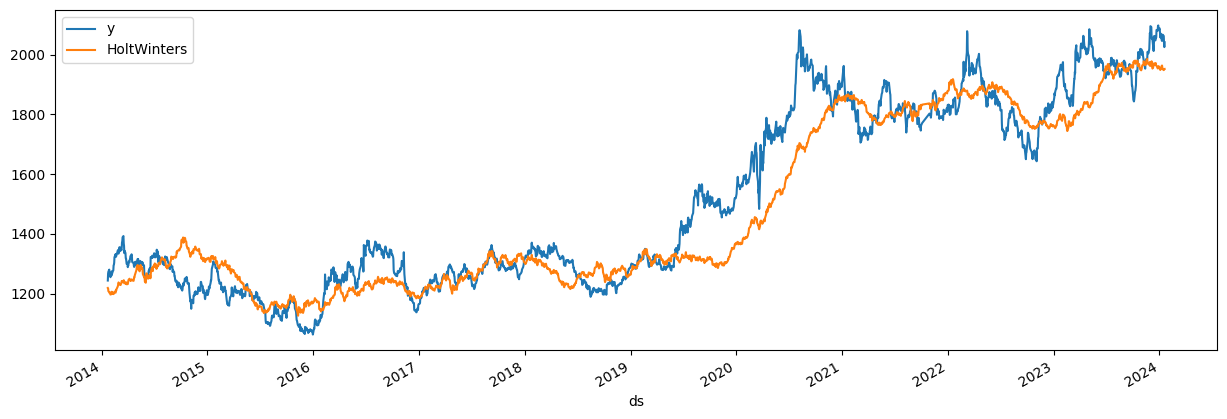

In [6]:
#set the date as the index column in the fitted data df
fitted_values_df.set_index('ds', inplace=True)
#Plot the fitted values (y) vs the predicted ones (Holtwinter)
fitted_values_df[['y','HoltWinters']].plot(figsize=(15, 5))

In [7]:
# extract the predictions for the last two years only
Last_Two_Years = fitted_values_df.loc["01-Jan-2022":]
# calculate the error metrics for the last two years predictions 
print("RMSE = ", mean_squared_error(y_true=Last_Two_Years['y'],y_pred=Last_Two_Years['HoltWinters']))
print("MAE = " , mean_absolute_error(y_true=Last_Two_Years['y'],y_pred=Last_Two_Years['HoltWinters']))
print("MAPE = ", mean_absolute_percentage_error(y_true=Last_Two_Years['y'],y_pred=Last_Two_Years['HoltWinters']))

RMSE =  9022.9
MAE =  77.26105
MAPE =  0.040454447


In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [9]:
# Import the time series dataset
df = pd.read_csv('goldstock.csv')
Data = df[['Date', 'High']].copy()
#set the data to the standard pandas format 
Data['Date'] = pd.to_datetime(df['Date'])
#rename the date and price columns into ds & y repectivly, this is also requirement by the StatsForecast library 
Data.rename(columns={'Date': 'ds', 'High': 'y'}, inplace=True)
Data.head()

,ds,y
0,2024-01-19,2041.9
1,2024-01-18,2025.6
2,2024-01-17,2036.1
3,2024-01-16,2062.8
4,2024-01-12,2067.3


In [10]:
#Train
model = Prophet(daily_seasonality=True)
model.fit(Data)

#Perdict
future = model.make_future_dataframe(periods=365, freq="D")  # Predicting the next 365 days
forecast = model.predict(future)
forecast

14:40:30 - cmdstanpy - INFO - Chain [1] start processing
14:40:31 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-22,1250.659387,1249.770424,1390.323848,1250.659387,1250.659387,70.998753,70.998753,70.998753,61.184435,...,2.720396,2.720396,2.720396,7.093923,7.093923,7.093923,0.0,0.0,0.0,1321.658140
1,2014-01-23,1250.443290,1254.636950,1384.426519,1250.443290,1250.443290,71.946042,71.946042,71.946042,61.184435,...,3.583163,3.583163,3.583163,7.178444,7.178444,7.178444,0.0,0.0,0.0,1322.389332
2,2014-01-24,1250.227193,1256.515040,1383.200729,1250.227193,1250.227193,71.959601,71.959601,71.959601,61.184435,...,3.539378,3.539378,3.539378,7.235787,7.235787,7.235787,0.0,0.0,0.0,1322.186794
3,2014-01-27,1249.578903,1255.290852,1390.106600,1249.578903,1249.578903,70.931507,70.931507,70.931507,61.184435,...,2.447823,2.447823,2.447823,7.299248,7.299248,7.299248,0.0,0.0,0.0,1320.510410
4,2014-01-28,1249.362806,1256.805002,1390.715195,1249.362806,1249.362806,71.491290,71.491290,71.491290,61.184435,...,3.005340,3.005340,3.005340,7.301515,7.301515,7.301515,0.0,0.0,0.0,1320.854096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,2025-01-14,2032.422474,1949.133257,2288.111565,1880.137008,2204.743579,69.043114,69.043114,69.043114,61.184435,...,3.005340,3.005340,3.005340,4.853338,4.853338,4.853338,0.0,0.0,0.0,2101.465588
2854,2025-01-15,2032.685436,1941.396382,2274.651280,1879.455184,2205.842537,69.259997,69.259997,69.259997,61.184435,...,2.720396,2.720396,2.720396,5.355166,5.355166,5.355166,0.0,0.0,0.0,2101.945433
2855,2025-01-16,2032.948398,1931.144412,2288.165407,1878.832702,2207.503571,70.549370,70.549370,70.549370,61.184435,...,3.583163,3.583163,3.583163,5.781771,5.781771,5.781771,0.0,0.0,0.0,2103.497767
2856,2025-01-17,2033.211360,1933.847125,2291.052655,1878.240004,2208.424704,70.863272,70.863272,70.863272,61.184435,...,3.539378,3.539378,3.539378,6.139459,6.139459,6.139459,0.0,0.0,0.0,2104.074631


c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


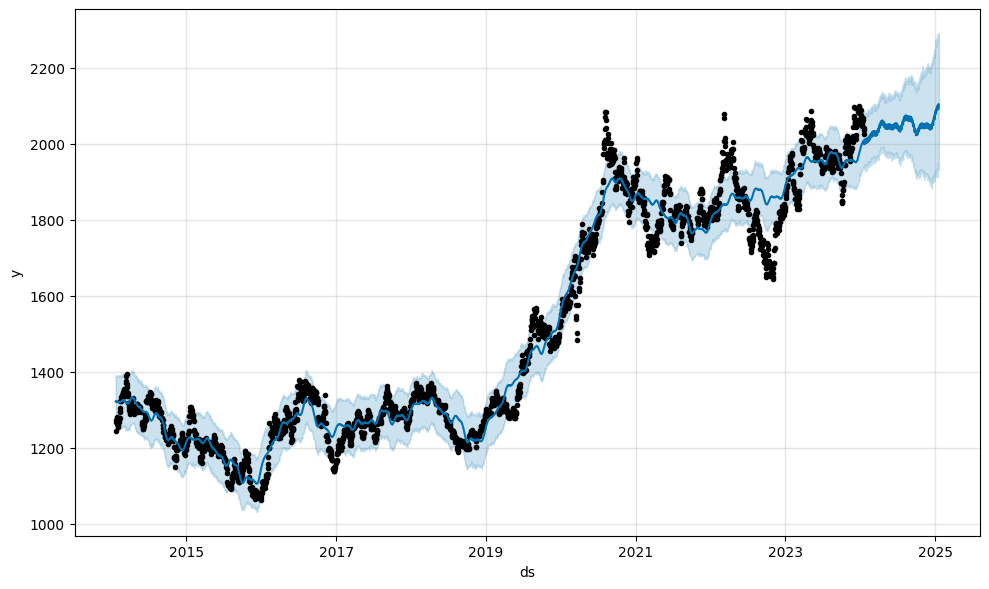

In [11]:
#Plot
fig1 = model.plot(forecast)
plt.show()

In [12]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='2000 days', horizon = '365 days')
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/8 [00:00<?, ?it/s]14:43:13 - cmdstanpy - INFO - Chain [1] start processing
14:43:13 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 1/8 [00:00<00:04,  1.40it/s]14:43:14 - cmdstanpy - INFO - Chain [1] start processing
14:43:14 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 2/8 [00:01<00:05,  1.17it/s]14:43:15 - cmdstanpy - INFO - Chain [1] start processing
14:43:16 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 3/8 [00:02<00:05,  1.01s/it]14:43:16 - cmdstanpy - INFO - Chain [1] start processing
14:43:17 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 4/8 [00:04<00:04,  1.07s/it]14:43:17 - cmdstanpy - INFO - Chain [1] start processing
14:43:18 - cmdstanpy - INFO - Chain [1] done processing
 62%|██████▎   | 5/8 [00:05<00:03,  1.11s/it]14:43:18 - cmdstanpy - INFO - Chain [1] start processing
14:43:19 - cmdstanpy - INFO - Chain [1] done processing
 75%|███████▌  | 6/8 [00:06<00:02,  1.02s/it]14:43:19 - cmds

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,35 days 12:00:00,18086.217153,134.485007,113.881188,0.063919,0.062050,0.064031,0.250000
1,36 days 00:00:00,18330.132530,135.388820,114.310047,0.064048,0.062050,0.064147,0.255000
2,36 days 12:00:00,18746.840347,136.919101,116.113577,0.065163,0.063569,0.065280,0.245000
3,37 days 00:00:00,19039.797203,137.984772,116.748272,0.065460,0.062483,0.065536,0.250000
4,37 days 12:00:00,19422.704605,139.365364,118.357736,0.066402,0.064746,0.066524,0.243333
...,...,...,...,...,...,...,...,...
650,363 days 00:00:00,88820.562152,298.027788,260.467877,0.140979,0.134424,0.137602,0.393333
651,363 days 12:00:00,88604.464842,297.665021,260.665138,0.141087,0.134608,0.137691,0.390000
652,364 days 00:00:00,89491.365620,299.151075,261.626031,0.141561,0.134608,0.137912,0.392500
653,364 days 12:00:00,90766.036233,301.274022,264.065408,0.142978,0.135828,0.139139,0.387500


c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


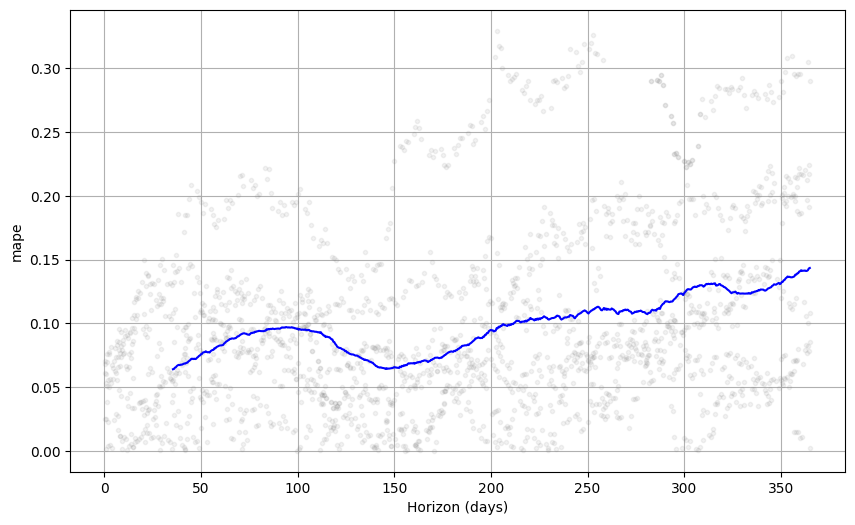

In [13]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
